In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import imutils
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 200
def BGR2RGB(img):
    img=img.copy()
    temp=img[:,:,0].copy()
    img[:,:,0]=img[:,:,2].copy()
    img[:,:,2]=temp
    return img
def reflection_pad(img,kernel_size):
    color_flag=len(img.shape)
    if color_flag==3:
        h,w,c = img.shape
        half_kernel_size = int(kernel_size//2)
        img_pad = np.zeros((h+half_kernel_size*2,w+half_kernel_size*2,3),dtype=img.dtype)
        img_pad[half_kernel_size : half_kernel_size+h ,half_kernel_size:half_kernel_size+w,:]=img
        img_pad[half_kernel_size : half_kernel_size+h, 0:half_kernel_size] = np.flip(img[:,0:half_kernel_size],axis=1)
        img_pad[half_kernel_size : half_kernel_size+h, -half_kernel_size:] = np.flip(img[:,-half_kernel_size:],axis=1)
        img_pad[0:half_kernel_size, half_kernel_size : -half_kernel_size] = np.flip(img[0:half_kernel_size ,:],axis=0)
        img_pad[-half_kernel_size:, half_kernel_size : -half_kernel_size] = np.flip(img[-half_kernel_size:,:],axis=0)

        img_pad[0:half_kernel_size,0:half_kernel_size]=np.flip(np.flip(img[0:half_kernel_size,0:half_kernel_size],axis=0),axis=1)
        img_pad[0:half_kernel_size,-half_kernel_size:]=np.flip(np.flip(img[0:half_kernel_size,-half_kernel_size:],axis=0),axis=1)
        img_pad[-half_kernel_size:,0:half_kernel_size]=np.flip(np.flip(img[-half_kernel_size:,0:half_kernel_size],axis=0),axis=1)
        img_pad[-half_kernel_size:,-half_kernel_size:]=np.flip(np.flip(img[-half_kernel_size:,-half_kernel_size:],axis=0),axis=1)
    else:
        h,w = img.shape
        half_kernel_size = int(kernel_size//2)
        img_pad = np.zeros((h+half_kernel_size*2,w+half_kernel_size*2),dtype=img.dtype)
        img_pad[half_kernel_size : half_kernel_size+h ,half_kernel_size:half_kernel_size+w]=img
        img_pad[half_kernel_size : half_kernel_size+h, 0:half_kernel_size] = np.flip(img[:,0:half_kernel_size],axis=1)
        img_pad[half_kernel_size : half_kernel_size+h, -half_kernel_size:] = np.flip(img[:,-half_kernel_size:],axis=1)
        img_pad[0:half_kernel_size, half_kernel_size : -half_kernel_size] = np.flip(img[0:half_kernel_size ,:],axis=0)
        img_pad[-half_kernel_size:, half_kernel_size : -half_kernel_size] = np.flip(img[-half_kernel_size:,:],axis=0)

        img_pad[0:half_kernel_size,0:half_kernel_size]=np.flip(np.flip(img[0:half_kernel_size,0:half_kernel_size],axis=0),axis=1)
        img_pad[0:half_kernel_size,-half_kernel_size:]=np.flip(np.flip(img[0:half_kernel_size,-half_kernel_size:],axis=0),axis=1)
        img_pad[-half_kernel_size:,0:half_kernel_size]=np.flip(np.flip(img[-half_kernel_size:,0:half_kernel_size],axis=0),axis=1)
        img_pad[-half_kernel_size:,-half_kernel_size:]=np.flip(np.flip(img[-half_kernel_size:,-half_kernel_size:],axis=0),axis=1)
    return img_pad
def min_filter(img_gray,kernel_size):
    half_kernel_size = kernel_size//2
    pad_img_gray = reflection_pad(img_gray,kernel_size)
    h,w = img_gray.shape    
    min_filter_img_gray=img_gray.copy()
    for i in range(h):
        for j in range(w):
            patch=pad_img_gray[i:i+kernel_size,j:j+kernel_size]
            min_filter_img_gray[i,j]=patch.min()
    return min_filter_img_gray
def get_dark_channel_init(img,kernel_size):
    h,w,c=img.shape
    b,g,r = cv2.split(img)
    b_filterd = min_filter(b,kernel_size)
    g_filterd = min_filter(g,kernel_size)
    r_filterd = min_filter(r,kernel_size)
#     rgb_filterd = cv2.merge(b_filterd,g_filterd,r_filterd)
    rgb_filterd = np.dstack([b_filterd,g_filterd,r_filterd])
    dark_channel = np.min(rgb_filterd,2)
    return dark_channel

def estimate_atmospheric_light(img,dark_channel,percent=0.001):
    h,w,c = img.shape
    flate_dark_channel=dark_channel.reshape(-1)
    flate_img = img.reshape(h*w,-1)
    sort_flate_dark_channel=sorted(range(len(flate_dark_channel)),key=lambda k: flate_dark_channel[k],reverse=True)
    top_num=int(percent*w*h)
    top_dark_channel=sort_flate_dark_channel[0:top_num]
    flate_img_mean = np.mean(flate_img,1)
    
#     top_img_mean=[]
#     for i in range(top_num):
#         top_img_mean.append(flate_img_mean[top_dark_channel[i]])
#     atmospheric_light = flate_img [top_img_mean.index(max(top_img_mean))]
#     print(sort_flate_dark_channel2[0:top_num])
#     flate_fog1_mean = np.mean(flate_fog1,1)
#     print(flate_fog1_mean[sort_flate_dark_channel2[0:top_num]])
#     print(np.max(flate_fog1_mean[sort_flate_dark_channel2[0:top_num]]))
    max_value=np.max(flate_img_mean[sort_flate_dark_channel[0:top_num]])
#     print(max_value)
#     print(flate_fog1_mean[3])
    flate_img_mean_top_list=flate_img_mean[sort_flate_dark_channel[0:top_num]]
#     print(list(flate_fog1_mean_top_list))
#     print(list(flate_fog1_mean_top_list).index(max_value))
#     idx=list(flate_fog1_mean_top_list).index(max_value)
    idx=np.argmax(flate_img_mean_top_list)
#     print(idx)
    idx_o=sort_flate_dark_channel[0:top_num][idx]
#     print(idx_o)
#     print(flate_fog1[idx_o])
    atmospheric_light = flate_img[idx_o]
    
    return atmospheric_light
    
    return atmospheric_light
def get_dark_channel_final(img,atmospheric_light,kernel_size):
    h,w,c=img.shape
    b,g,r = cv2.split(img)
    b_filterd = min_filter(b,kernel_size)/atmospheric_light[0]
    g_filterd = min_filter(g,kernel_size)/atmospheric_light[1]
    r_filterd = min_filter(r,kernel_size)/atmospheric_light[2]
#     rgb_filterd = cv2.merge(b_filterd,g_filterd,r_filterd)
    rgb_filterd = np.dstack([b_filterd,g_filterd,r_filterd])
    dark_channel_final = np.min(rgb_filterd,2)
    return dark_channel_final
def estimate_transmission(dark_channel_final,w=0.95):
    t = 1 - w * dark_channel_final
    return t
def revocer_sence_radiance(img,t,atmospheric_light,t0=0.1):
#     img_f = img.astype(np.float64) / 255
#     atmospheric_light_f = atmospheric_light.astype(np.float64) / 255
    img_f=img 
    atmospheric_light_f = atmospheric_light
    cut = (np.clip(t,t0,1))
#     print(cut.shape)
#     cut_3 = np.zeros(img.shape)
#     cut_3[:,:,0]=cut
#     cut_3[:,:,1]=cut
#     cut_3[:,:,2]=cut
#     J = ((img-atmospheric_light)/cut_3).astype(np.uint8) + atmospheric_light
    J = np.zeros_like(img_f)
#     print(atmospheric_light_f.shape)
    for i in range(3):
#         print(atmospheric_light_f[i])
#         print((img_f[:,:,i]-atmospheric_light_f[i]).shape)
#         J[:,:,i] = (img_f[:,:,i]-10.2)
#         J[:,:,i] = (img_f[:,:,i]-atmospheric_light_f[i])
        J[:,:,i] = (img_f[:,:,i]-atmospheric_light_f[i])/ cut + atmospheric_light_f[i]
#     print(np.min(J))
#     J=(J*255).astype(np.uint8)
    print('J_min: ',np.min(J))
    print('J_max: ',np.max(J))
    J = (np.clip(J,0,1))
    return J
def boxfilter(img, r):
#     (rows, cols) = img.shape
    rows=img.shape[0]
    cols=img.shape[1]
    img_filter = np.zeros_like(img)

    img_cum = np.cumsum(img, 0)
    img_filter[0 : r+1, :] = img_cum[r : 2*r+1, :]
    img_filter[r+1 : rows-r, :] = img_cum[2*r+1 : rows, :] - img_cum[0 : rows-2*r-1, :]
    img_filter[rows-r: rows, :] = np.tile(img_cum[rows-1, :], [r, 1]) - img_cum[rows-2*r-1 : rows-r-1, :]

    img_cum = np.cumsum(img_filter, 1)
    img_filter[:, 0 : r+1] = img_cum[:, r : 2*r+1]
    img_filter[:, r+1 : cols-r] = img_cum[:, 2*r+1 : cols] - img_cum[:, 0 : cols-2*r-1]
    img_filter[:, cols-r: cols] = np.tile(img_cum[:, cols-1], [r, 1]).T - img_cum[:, cols-2*r-1 : cols-r-1]
    
    return img_filter
def guided_filter(f_img,g_img,kernel_size,reg = 0.25):
    # my implement
    h=f_img.shape[0]
    w=f_img.shape[1]
    r = int(kernel_size//2)
    N = boxfilter(np.ones((h,w)), r)
    mean_f_img = boxfilter(f_img , r)/N
    mean_g_img = boxfilter(g_img , r)/N
    mean_fg  = boxfilter(f_img * g_img , r)/N
    cov_fg = mean_fg - mean_f_img * mean_g_img
    
    mean_gg = boxfilter(g_img*g_img , r)/N
    var_g = mean_gg - mean_g_img * mean_g_img
    a =  cov_fg/(var_g + reg)
    b = mean_f_img - a * mean_g_img
    mean_a = boxfilter(a , r)/N
    mean_b = boxfilter(b , r)/N
    filtered_img = mean_a * g_img + mean_b
    return filtered_img

atmospheric_light:  [0.75294118 0.74509804 0.74117647]
dark_channel_final_min:  0.2486772486772487
dark_channel_final_max:  0.9421052631578947
transmission_min:  0.1050000000000001
transmission_max:  0.7637566137566137
transmission_final_min:  0.10895457023943664
transmission_final_max:  0.7780322676408213
J_min:  -0.03602280288185111
J_max:  1.3067730891525675


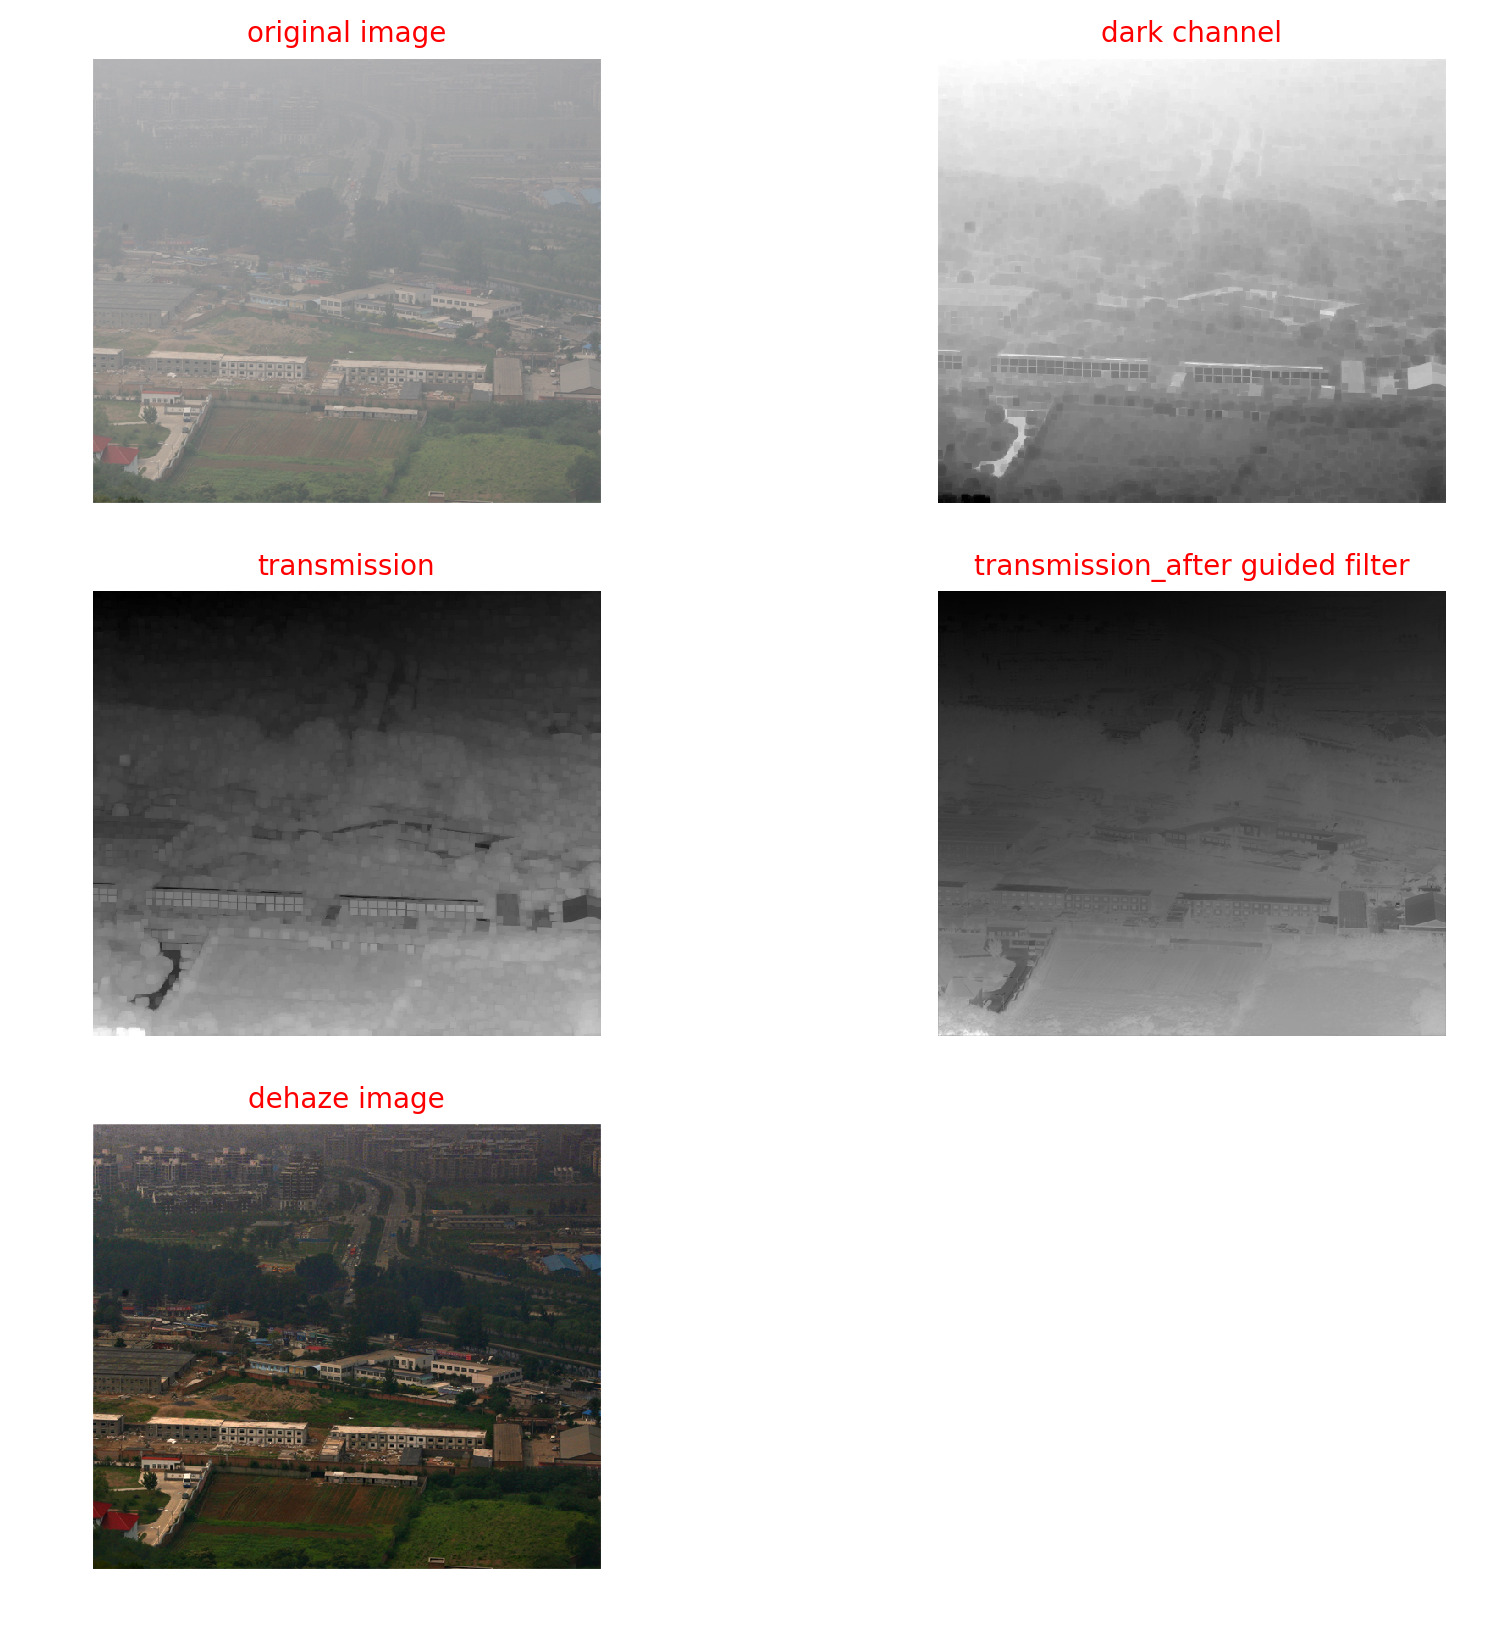

In [14]:
dark_channel_kernel_size = 7
guided_filter_kernel_size = 50
# reg=0.3**2
reg=0.0001
w = 0.95
img=cv2.imread('fog1.jpg')
# img=cv2.imread('fog7.png')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = img.astype('float64') / 255
img_gray = img_gray.astype('float64') / 255
# dark_channel_kernel_size = 7
dark_channel_init = get_dark_channel_init(img,dark_channel_kernel_size)
atmospheric_light = estimate_atmospheric_light(img,dark_channel_init,percent=0.001)
dark_channel_final = get_dark_channel_final(img,atmospheric_light,dark_channel_kernel_size)
print('atmospheric_light: ',atmospheric_light)
print('dark_channel_final_min: ',np.min(dark_channel_final))
print('dark_channel_final_max: ',np.max(dark_channel_final))
transmission = estimate_transmission(dark_channel_final,w)
transmission_final = guided_filter(transmission,img_gray,guided_filter_kernel_size,reg)
# transmission_final = guided_filter2(transmission,img_gray,guided_filter_kernel_size,reg)
print('transmission_min: ',np.min(transmission))
print('transmission_max: ',np.max(transmission))
print('transmission_final_min: ',np.min(transmission_final))
print('transmission_final_max: ',np.max(transmission_final))
J=revocer_sence_radiance(img,transmission_final,atmospheric_light,t0=0.1)
# J=revocer_sence_radiance(img,transmission,atmospheric_light,t0=0.1)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.subplot(321)
plt.axis('off')
plt.title('original image',fontsize=10,color='r')
plt.imshow(BGR2RGB(img))
plt.subplot(322)
plt.axis('off')
plt.title('dark channel',fontsize=10,color='r')
plt.imshow(dark_channel_final)
# plt.imshow(dark_channel_init)
plt.subplot(323)
plt.axis('off')
plt.title('transmission',fontsize=10,color='r')
plt.imshow(transmission)
plt.subplot(324)
plt.axis('off')
plt.title('transmission_after guided filter',fontsize=10,color='r')
plt.imshow(transmission_final)
plt.subplot(325)
plt.axis('off')
plt.title('dehaze image',fontsize=10,color='r')
plt.imshow(BGR2RGB(J))
fig = plt.gcf()
fig.savefig('reslut1.png', dpi=200)

atmospheric_light:  [0.64705882 0.68627451 0.68627451]
dark_channel_final_min:  0.011428571428571429
dark_channel_final_max:  0.9878787878787878
transmission_min:  0.40727272727272734
transmission_max:  0.9931428571428571
transmission_final_min:  0.44889337355186054
transmission_final_max:  0.9555599063280408
J_min:  -0.02370857765738532
J_max:  0.8632292420648301


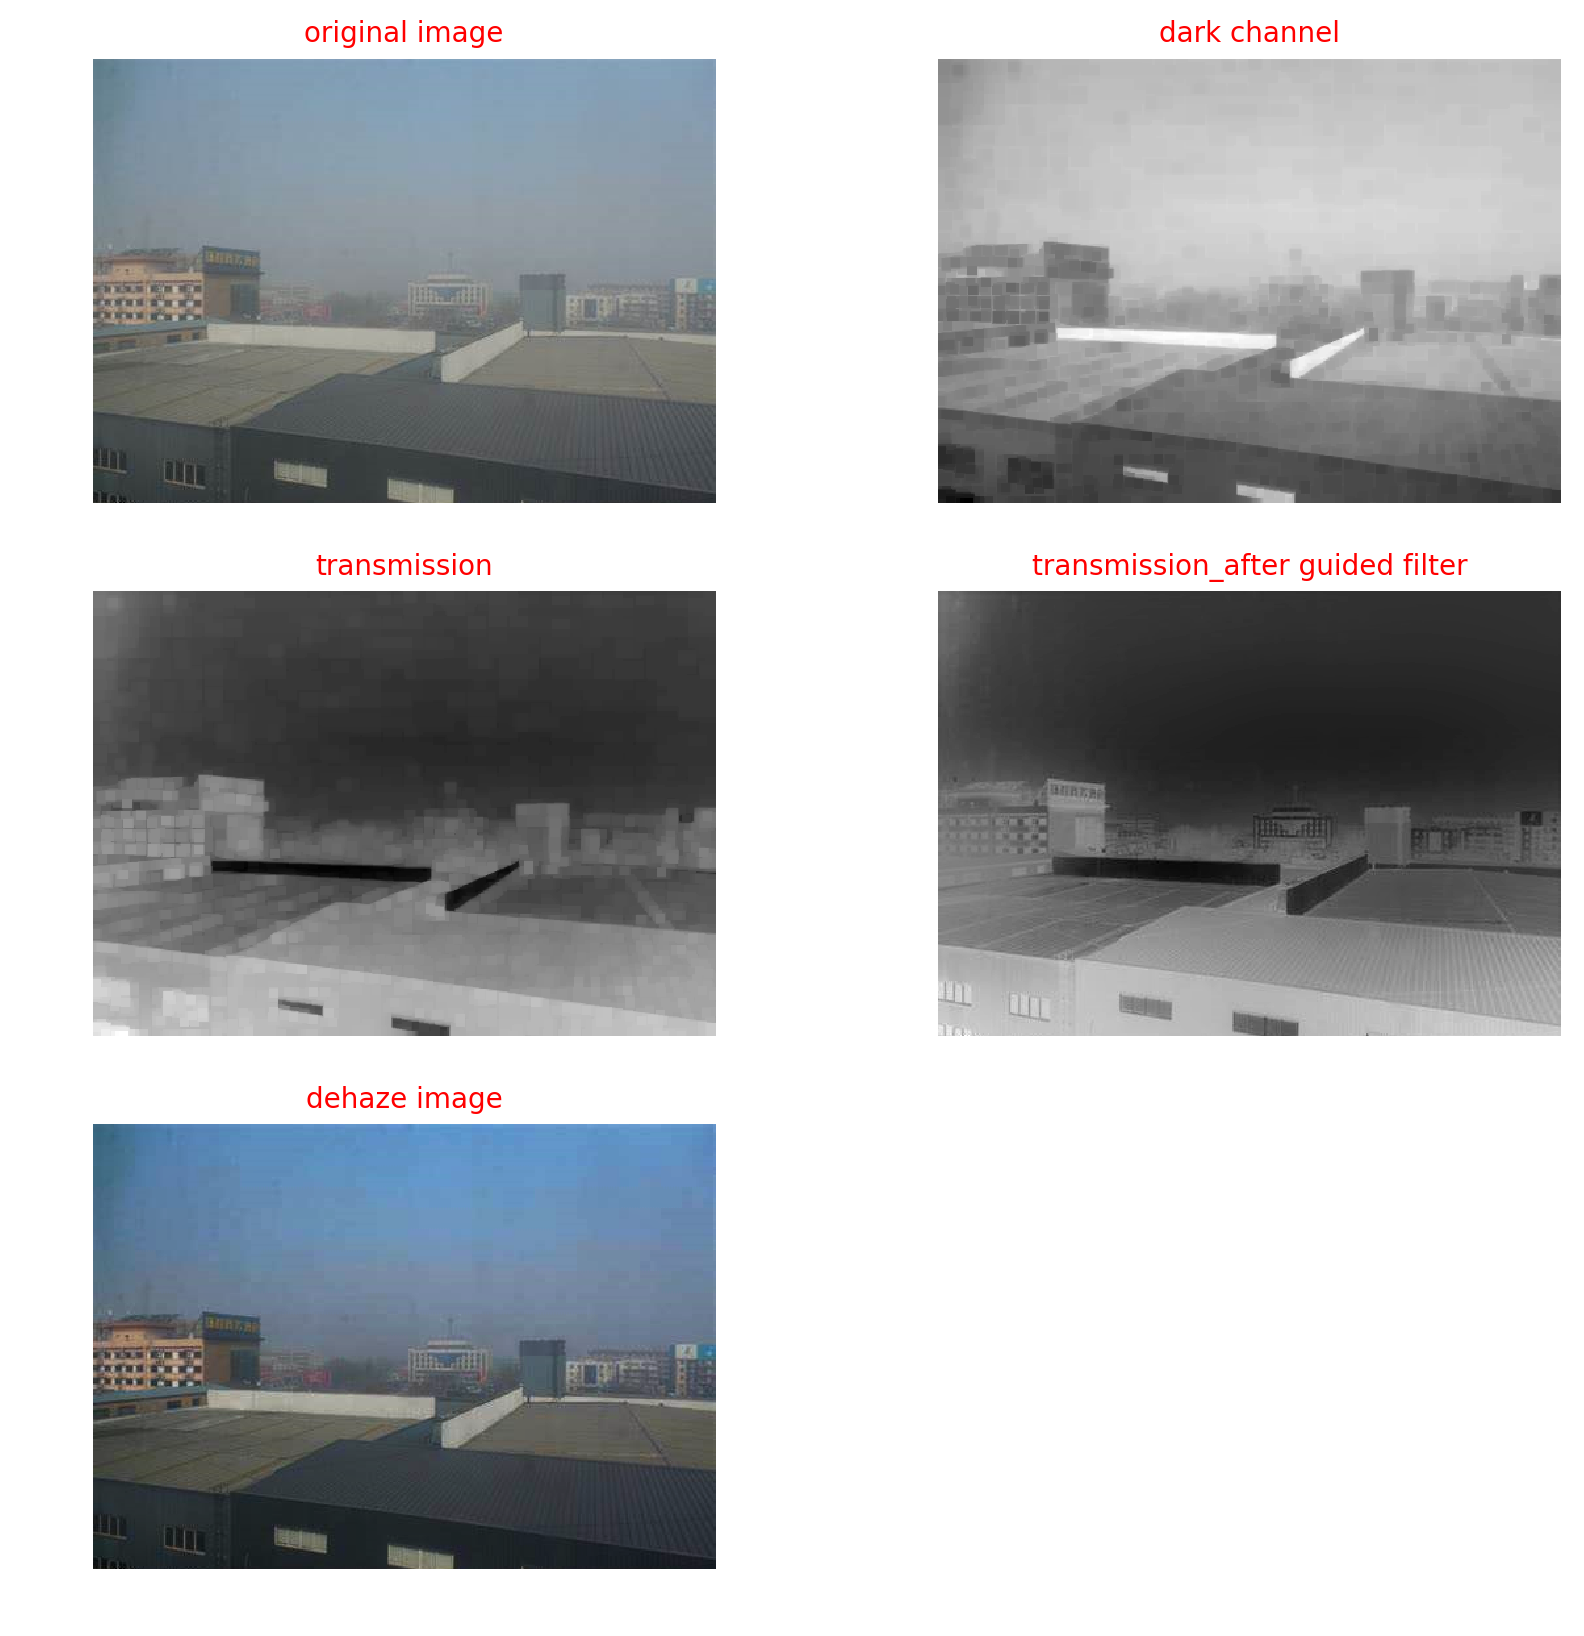

In [15]:
dark_channel_kernel_size = 7
guided_filter_kernel_size = 70
# reg=0.5**2
reg=0.0001
w = 0.60
img=cv2.imread('fog2.jpg')
# img=cv2.imread('fog7.png')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = img.astype('float64') / 255
img_gray = img_gray.astype('float64') / 255
# dark_channel_kernel_size = 7
dark_channel_init = get_dark_channel_init(img,dark_channel_kernel_size)
atmospheric_light = estimate_atmospheric_light(img,dark_channel_init,percent=0.001)
dark_channel_final = get_dark_channel_final(img,atmospheric_light,dark_channel_kernel_size)
print('atmospheric_light: ',atmospheric_light)
print('dark_channel_final_min: ',np.min(dark_channel_final))
print('dark_channel_final_max: ',np.max(dark_channel_final))
transmission = estimate_transmission(dark_channel_final,w)
transmission_final = guided_filter(transmission,img_gray,guided_filter_kernel_size,reg)
# transmission_final = guided_filter2(transmission,img_gray,guided_filter_kernel_size,reg)
print('transmission_min: ',np.min(transmission))
print('transmission_max: ',np.max(transmission))
print('transmission_final_min: ',np.min(transmission_final))
print('transmission_final_max: ',np.max(transmission_final))
# dark_channel_final = dark_channel_init
# transmission = estimate_transmission(dark_channel_final,0.95)
J=revocer_sence_radiance(img,transmission_final,atmospheric_light,t0=0.1)
# J=revocer_sence_radiance(img,transmission,atmospheric_light,t0=0.1)
plt.rcParams['figure.dpi'] = 200
plt.subplot(321)
plt.axis('off')
plt.title('original image',fontsize=10,color='r')
plt.imshow(BGR2RGB(img))
plt.subplot(322)
plt.axis('off')
plt.title('dark channel',fontsize=10,color='r')
plt.imshow(dark_channel_final)
# plt.imshow(dark_channel_init)
plt.subplot(323)
plt.axis('off')
plt.title('transmission',fontsize=10,color='r')
plt.imshow(transmission)
plt.subplot(324)
plt.axis('off')
plt.title('transmission_after guided filter',fontsize=10,color='r')
plt.imshow(transmission_final)
plt.subplot(325)
plt.axis('off')
plt.title('dehaze image',fontsize=10,color='r')
plt.imshow(BGR2RGB(J))
fig = plt.gcf()
fig.savefig('reslut2.png', dpi=200)

atmospheric_light:  [0.85098039 0.84313725 0.84313725]
dark_channel_final_min:  0.027649769585253458
dark_channel_final_max:  0.9906976744186047
transmission_min:  0.25697674418604644
transmission_max:  0.9792626728110599
transmission_final_min:  0.26221059563086063
transmission_final_max:  0.99109909181224
J_min:  -0.08106618890689787
J_max:  0.8560719647411713


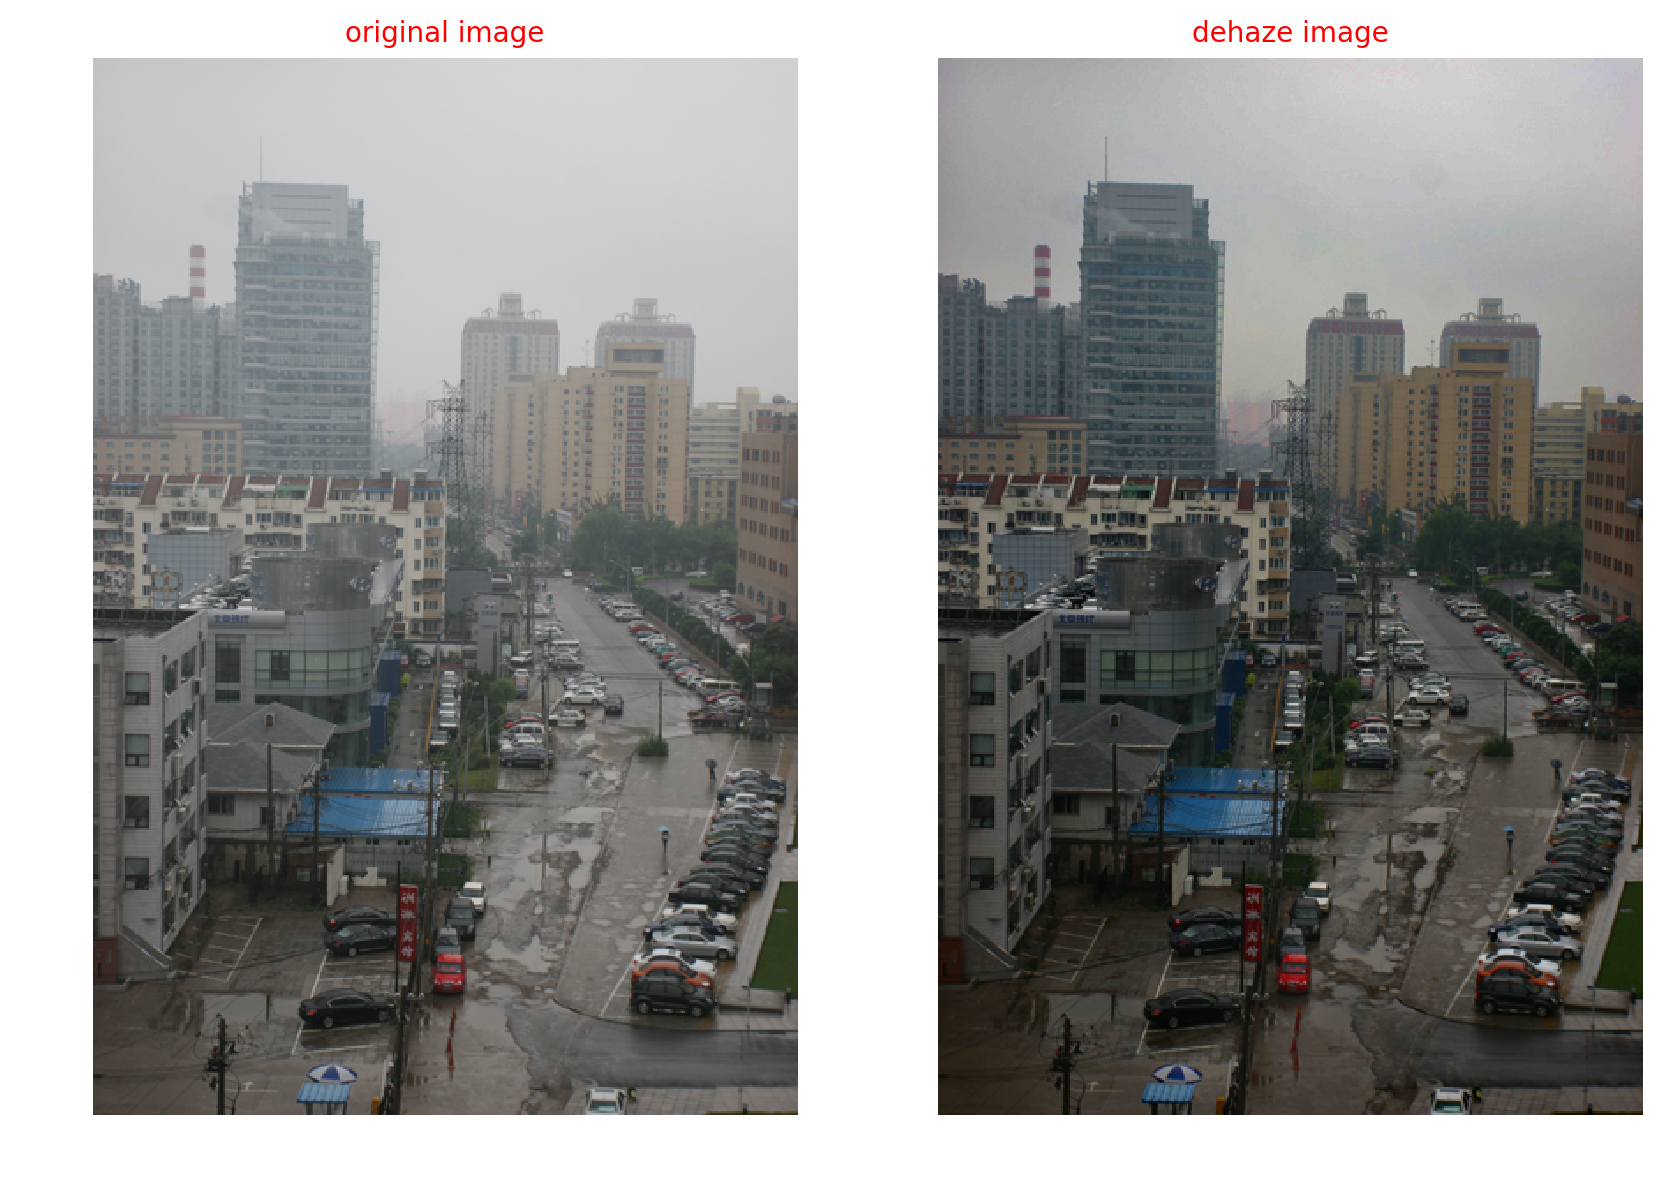

In [24]:
dark_channel_kernel_size = 7
guided_filter_kernel_size = 50
reg=0.0001
w = 0.75
img=cv2.imread('fog4.png')
# img=cv2.imread('fog7.png')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = img.astype('float64') / 255
img_gray = img_gray.astype('float64') / 255
dark_channel_init = get_dark_channel_init(img,dark_channel_kernel_size)
atmospheric_light = estimate_atmospheric_light(img,dark_channel_init,percent=0.001)
dark_channel_final = get_dark_channel_final(img,atmospheric_light,dark_channel_kernel_size)
print('atmospheric_light: ',atmospheric_light)
print('dark_channel_final_min: ',np.min(dark_channel_final))
print('dark_channel_final_max: ',np.max(dark_channel_final))
transmission = estimate_transmission(dark_channel_final,w)
transmission_final = guided_filter(transmission,img_gray,guided_filter_kernel_size,reg)
# transmission_final = guided_filter2(transmission,img_gray,guided_filter_kernel_size,reg)
print('transmission_min: ',np.min(transmission))
print('transmission_max: ',np.max(transmission))
print('transmission_final_min: ',np.min(transmission_final))
print('transmission_final_max: ',np.max(transmission_final))
# dark_channel_final = dark_channel_init
# transmission = estimate_transmission(dark_channel_final,0.95)
J=revocer_sence_radiance(img,transmission_final,atmospheric_light,t0=0.1)
# J=revocer_sence_radiance(img,transmission,atmospheric_light,t0=0.1)
plt.rcParams['figure.dpi'] = 200
plt.subplot(121)
plt.axis('off')
plt.title('original image',fontsize=10,color='r')
plt.imshow(BGR2RGB(img))
plt.subplot(122)
plt.axis('off')
plt.title('dehaze image',fontsize=10,color='r')
plt.imshow(BGR2RGB(J))

atmospheric_light:  [0.68627451 0.72156863 0.75686275]
dark_channel_final_min:  0.022857142857142857
dark_channel_final_max:  0.9585492227979274
transmission_min:  0.2810880829015544
transmission_max:  0.9828571428571429
transmission_final_min:  0.2944169880411204
transmission_final_max:  1.0718377154046546
J_min:  -0.06702339731139595
J_max:  1.0545630525980159


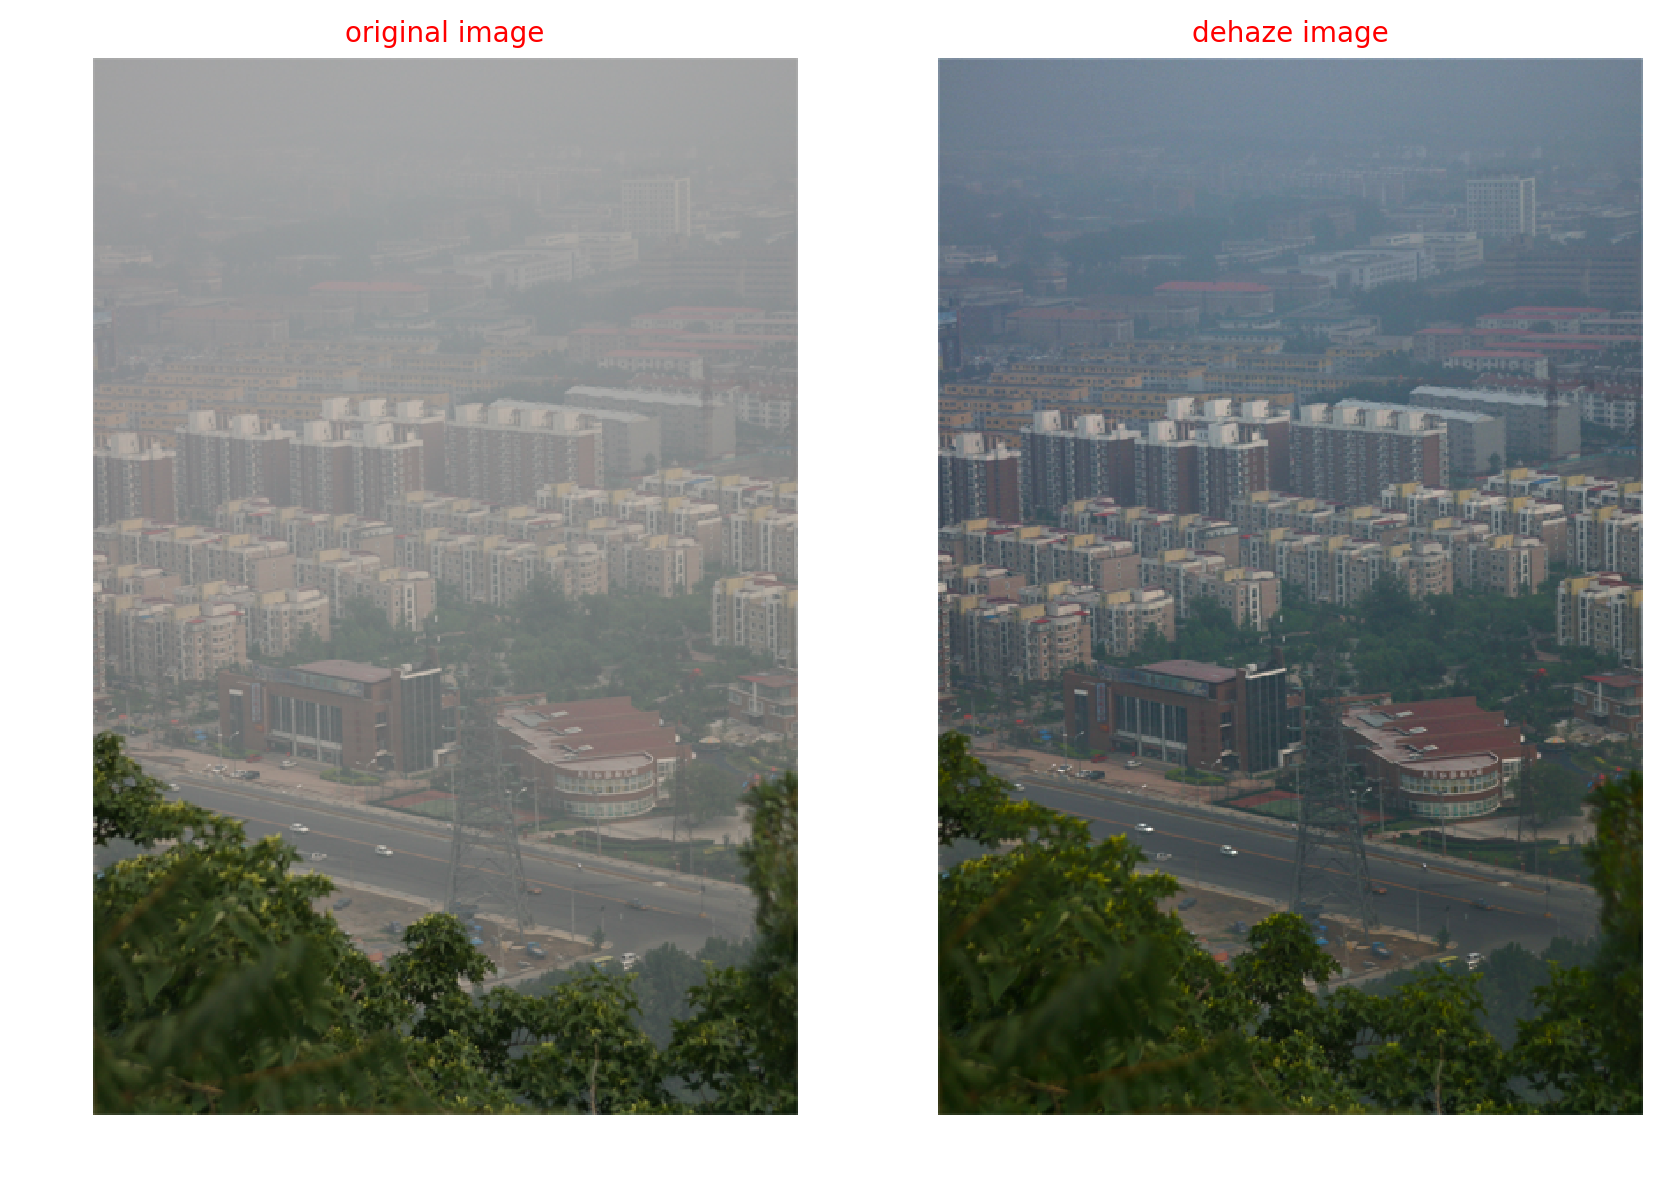

In [26]:
dark_channel_kernel_size = 7
guided_filter_kernel_size = 100
reg=0.0001
w = 0.75
img=cv2.imread('fog5.bmp')
# img=cv2.imread('fog7.png')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = img.astype('float64') / 255
img_gray = img_gray.astype('float64') / 255
dark_channel_init = get_dark_channel_init(img,dark_channel_kernel_size)
atmospheric_light = estimate_atmospheric_light(img,dark_channel_init,percent=0.001)
dark_channel_final = get_dark_channel_final(img,atmospheric_light,dark_channel_kernel_size)
print('atmospheric_light: ',atmospheric_light)
print('dark_channel_final_min: ',np.min(dark_channel_final))
print('dark_channel_final_max: ',np.max(dark_channel_final))
transmission = estimate_transmission(dark_channel_final,w)
transmission_final = guided_filter(transmission,img_gray,guided_filter_kernel_size,reg)
# transmission_final = guided_filter2(transmission,img_gray,guided_filter_kernel_size,reg)
print('transmission_min: ',np.min(transmission))
print('transmission_max: ',np.max(transmission))
print('transmission_final_min: ',np.min(transmission_final))
print('transmission_final_max: ',np.max(transmission_final))
# dark_channel_final = dark_channel_init
# transmission = estimate_transmission(dark_channel_final,0.95)
J=revocer_sence_radiance(img,transmission_final,atmospheric_light,t0=0.1)
# J=revocer_sence_radiance(img,transmission,atmospheric_light,t0=0.1)
plt.rcParams['figure.dpi'] = 200
plt.subplot(121)
plt.axis('off')
plt.title('original image',fontsize=10,color='r')
plt.imshow(BGR2RGB(img))
plt.subplot(122)
plt.axis('off')
plt.title('dehaze image',fontsize=10,color='r')
plt.imshow(BGR2RGB(J))

atmospheric_light:  [0.78431373 0.87058824 0.90980392]
dark_channel_final_min:  0.04
dark_channel_final_max:  0.97
transmission_min:  0.27249999999999996
transmission_max:  0.97
transmission_final_min:  0.2743453852176321
transmission_final_max:  1.0098467192799685
J_min:  -0.043319287496497605
J_max:  0.9447019060003853


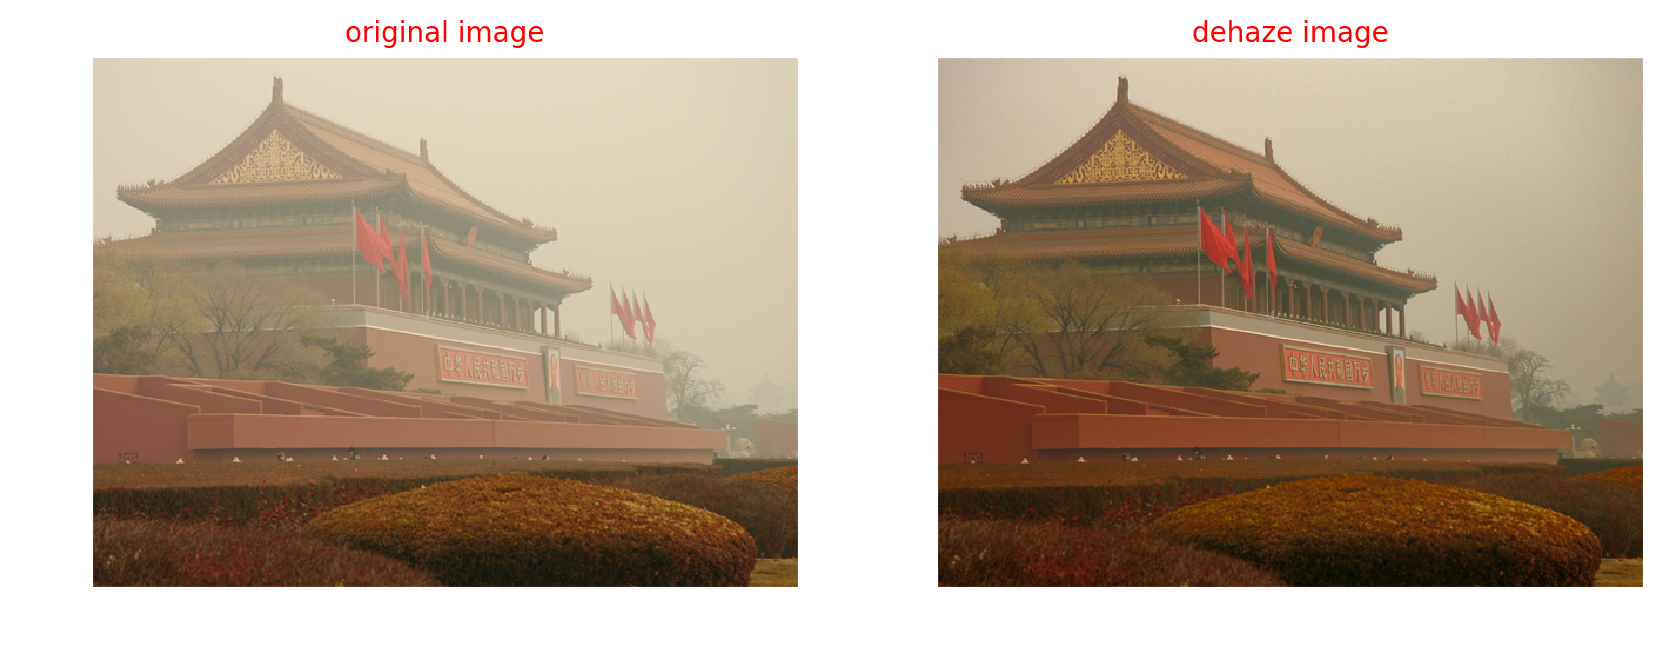

In [32]:
dark_channel_kernel_size = 15
guided_filter_kernel_size = 100
reg=0.0001
w = 0.75
img=cv2.imread('fog6.png')
# img=cv2.imread('fog7.png')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = img.astype('float64') / 255
img_gray = img_gray.astype('float64') / 255
dark_channel_init = get_dark_channel_init(img,dark_channel_kernel_size)
atmospheric_light = estimate_atmospheric_light(img,dark_channel_init,percent=0.001)
dark_channel_final = get_dark_channel_final(img,atmospheric_light,dark_channel_kernel_size)
print('atmospheric_light: ',atmospheric_light)
print('dark_channel_final_min: ',np.min(dark_channel_final))
print('dark_channel_final_max: ',np.max(dark_channel_final))
transmission = estimate_transmission(dark_channel_final,w)
transmission_final = guided_filter(transmission,img_gray,guided_filter_kernel_size,reg)
# transmission_final = guided_filter2(transmission,img_gray,guided_filter_kernel_size,reg)
print('transmission_min: ',np.min(transmission))
print('transmission_max: ',np.max(transmission))
print('transmission_final_min: ',np.min(transmission_final))
print('transmission_final_max: ',np.max(transmission_final))
# dark_channel_final = dark_channel_init
# transmission = estimate_transmission(dark_channel_final,0.95)
J=revocer_sence_radiance(img,transmission_final,atmospheric_light,t0=0.2)
# J=revocer_sence_radiance(img,transmission,atmospheric_light,t0=0.1)
plt.rcParams['figure.dpi'] = 200
plt.subplot(121)
plt.axis('off')
plt.title('original image',fontsize=10,color='r')
plt.imshow(BGR2RGB(img))
plt.subplot(122)
plt.axis('off')
plt.title('dehaze image',fontsize=10,color='r')
plt.imshow(BGR2RGB(J))

atmospheric_light:  [0.94901961 0.90980392 0.89803922]
dark_channel_final_min:  0.004132231404958678
dark_channel_final_max:  0.8140495867768596
transmission_min:  0.2266528925619834
transmission_max:  0.9960743801652893
transmission_final_min:  0.4580817252106414
transmission_final_max:  0.9902607516123199
J_min:  -0.09308441372287457
J_max:  1.0333303438358175


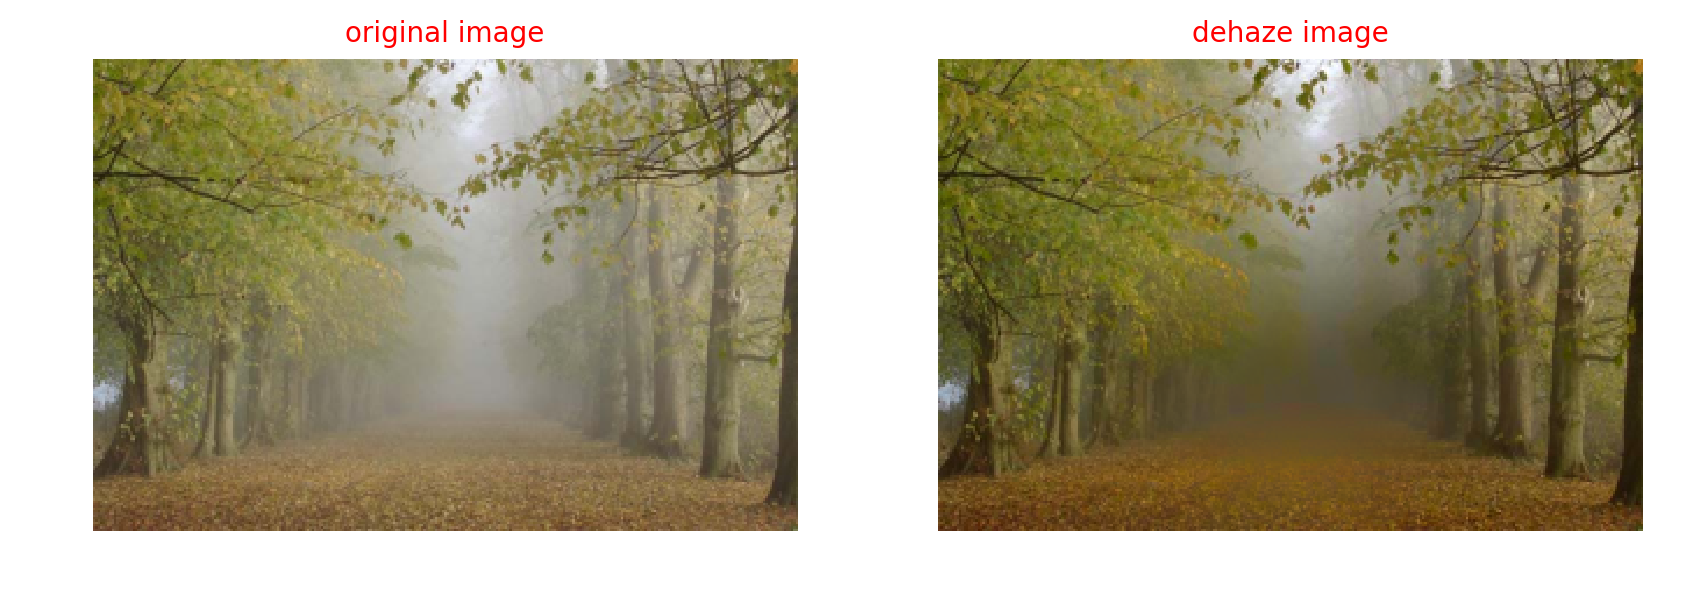

In [35]:
dark_channel_kernel_size = 15
guided_filter_kernel_size = 50
reg=0.0001
w = 0.95
img=cv2.imread('fog7.png')
# img=cv2.imread('fog7.png')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = img.astype('float64') / 255
img_gray = img_gray.astype('float64') / 255
dark_channel_init = get_dark_channel_init(img,dark_channel_kernel_size)
atmospheric_light = estimate_atmospheric_light(img,dark_channel_init,percent=0.001)
dark_channel_final = get_dark_channel_final(img,atmospheric_light,dark_channel_kernel_size)
print('atmospheric_light: ',atmospheric_light)
print('dark_channel_final_min: ',np.min(dark_channel_final))
print('dark_channel_final_max: ',np.max(dark_channel_final))
transmission = estimate_transmission(dark_channel_final,w)
transmission_final = guided_filter(transmission,img_gray,guided_filter_kernel_size,reg)
# transmission_final = guided_filter2(transmission,img_gray,guided_filter_kernel_size,reg)
print('transmission_min: ',np.min(transmission))
print('transmission_max: ',np.max(transmission))
print('transmission_final_min: ',np.min(transmission_final))
print('transmission_final_max: ',np.max(transmission_final))
# dark_channel_final = dark_channel_init
# transmission = estimate_transmission(dark_channel_final,0.95)
J=revocer_sence_radiance(img,transmission_final,atmospheric_light,t0=0.2)
# J=revocer_sence_radiance(img,transmission,atmospheric_light,t0=0.1)
plt.rcParams['figure.dpi'] = 200
plt.subplot(121)
plt.axis('off')
plt.title('original image',fontsize=10,color='r')
plt.imshow(BGR2RGB(img))
plt.subplot(122)
plt.axis('off')
plt.title('dehaze image',fontsize=10,color='r')
plt.imshow(BGR2RGB(J))

atmospheric_light:  [0.75294118 0.74509804 0.74117647]
dark_channel_final_min:  0.2486772486772487
dark_channel_final_max:  0.9421052631578947
transmission_min:  0.1050000000000001
transmission_max:  0.7637566137566137
transmission_final_min:  0.11550381767668089
transmission_final_max:  0.7925458928439229
J_min:  -0.025361531655203273
J_max:  1.1913499843206279


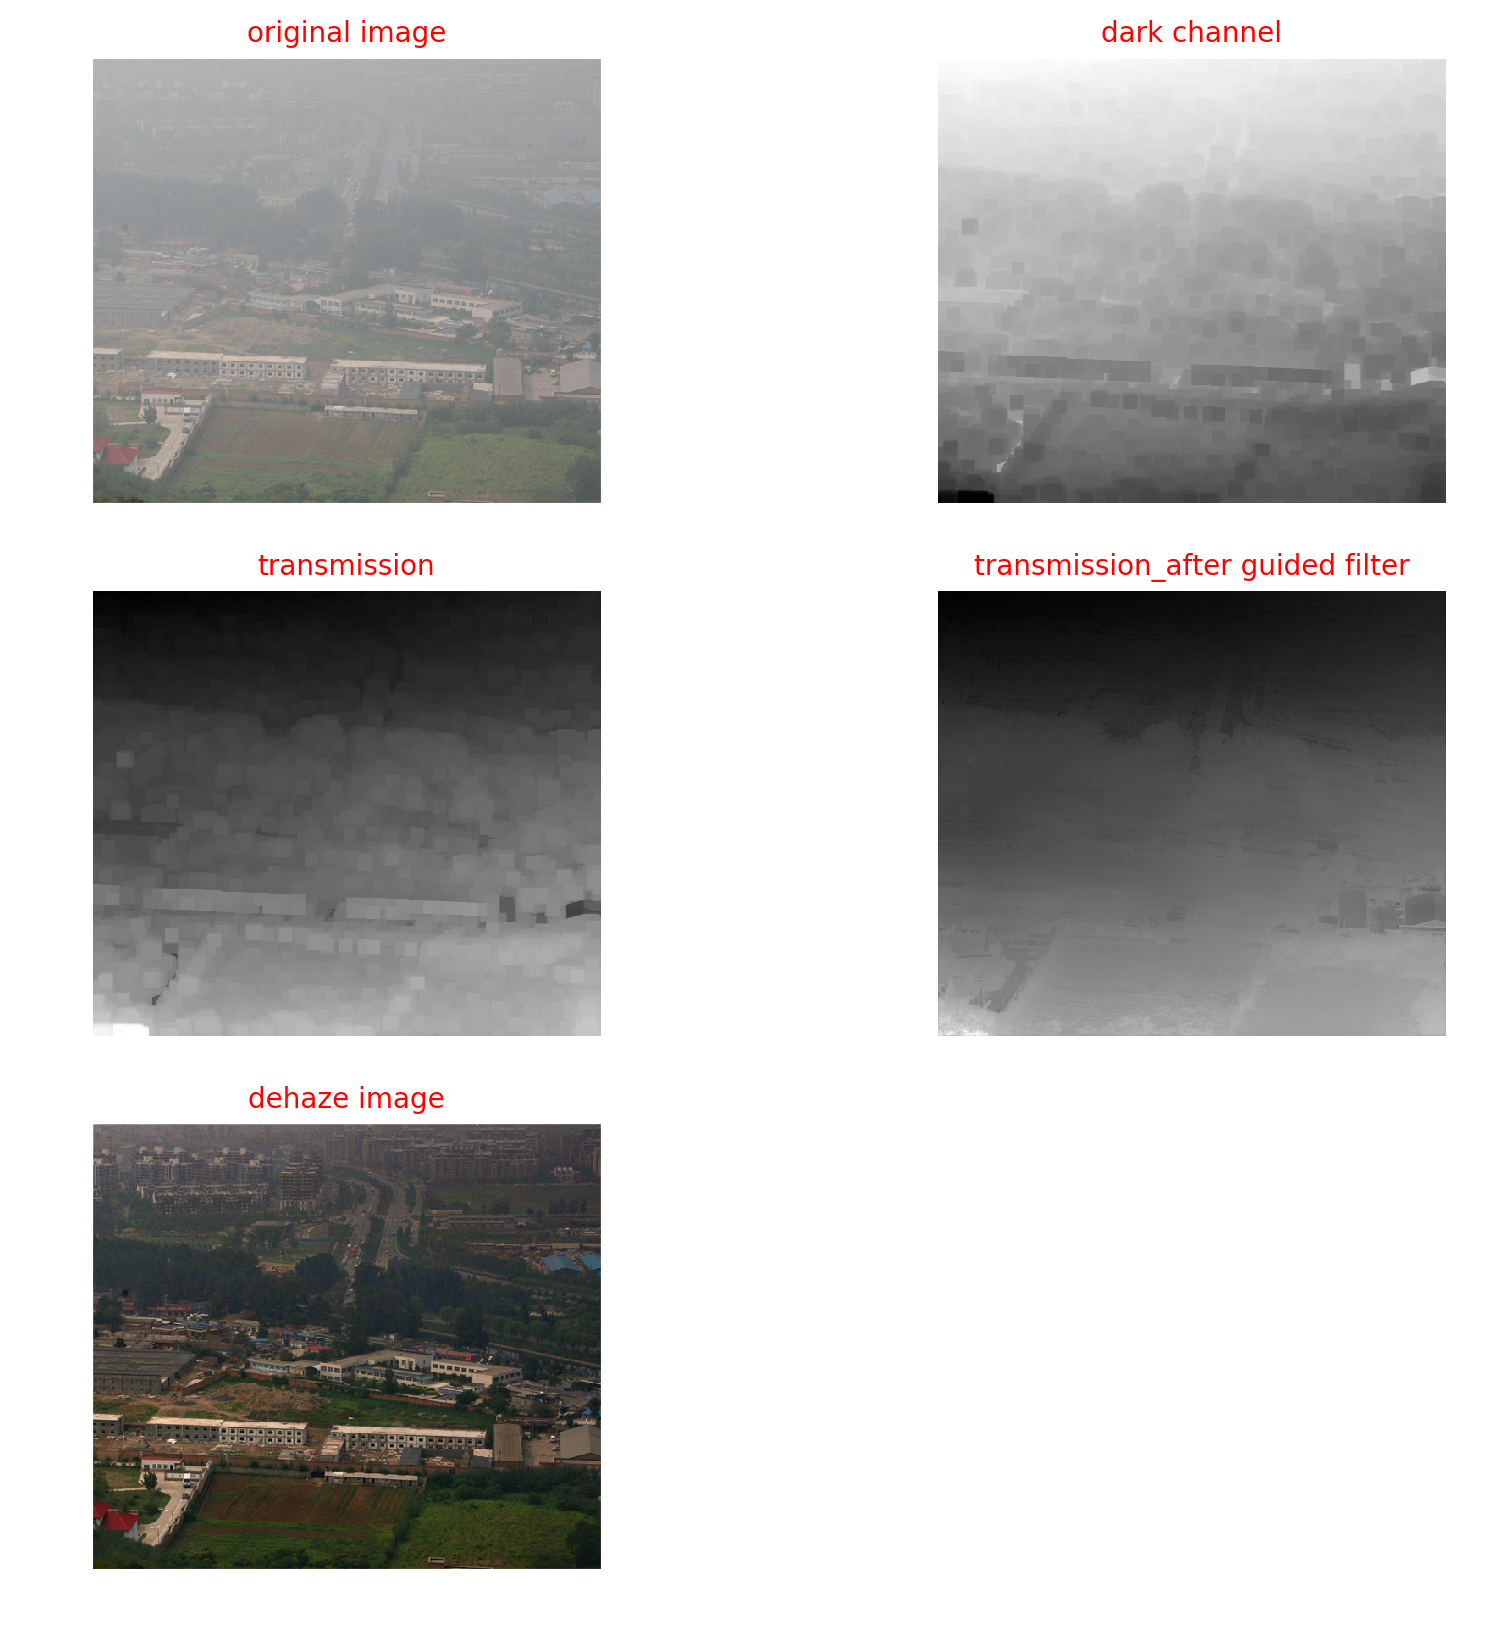

In [45]:
dark_channel_kernel_size = 15
guided_filter_kernel_size = 50
# reg=0.3**2
reg=0.0001
w = 0.95
img=cv2.imread('fog1.jpg')
# img=cv2.imread('fog7.png')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = img.astype('float64') / 255
img_gray = img_gray.astype('float64') / 255
# dark_channel_kernel_size = 7
dark_channel_init = get_dark_channel_init(img,dark_channel_kernel_size)
atmospheric_light = estimate_atmospheric_light(img,dark_channel_init,percent=0.001)
dark_channel_final = get_dark_channel_final(img,atmospheric_light,dark_channel_kernel_size)
print('atmospheric_light: ',atmospheric_light)
print('dark_channel_final_min: ',np.min(dark_channel_final))
print('dark_channel_final_max: ',np.max(dark_channel_final))
transmission = estimate_transmission(dark_channel_final,w)
transmission_final = guided_filter(transmission,img_gray,guided_filter_kernel_size,reg)
# transmission_final = guided_filter2(transmission,img_gray,guided_filter_kernel_size,reg)
print('transmission_min: ',np.min(transmission))
print('transmission_max: ',np.max(transmission))
print('transmission_final_min: ',np.min(transmission_final))
print('transmission_final_max: ',np.max(transmission_final))
J=revocer_sence_radiance(img,transmission_final,atmospheric_light,t0=0.1)
# J=revocer_sence_radiance(img,transmission,atmospheric_light,t0=0.1)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.subplot(321)
plt.axis('off')
plt.title('original image',fontsize=10,color='r')
plt.imshow(BGR2RGB(img))
plt.subplot(322)
plt.axis('off')
plt.title('dark channel',fontsize=10,color='r')
plt.imshow(dark_channel_final)
# plt.imshow(dark_channel_init)
plt.subplot(323)
plt.axis('off')
plt.title('transmission',fontsize=10,color='r')
plt.imshow(transmission)
plt.subplot(324)
plt.axis('off')
plt.title('transmission_after guided filter',fontsize=10,color='r')
plt.imshow(transmission_final)
plt.subplot(325)
plt.axis('off')
plt.title('dehaze image',fontsize=10,color='r')
plt.imshow(BGR2RGB(J))

atmospheric_light:  [0.75294118 0.74509804 0.74117647]
dark_channel_final_min:  0.2486772486772487
dark_channel_final_max:  0.9421052631578947
transmission_min:  0.1050000000000001
transmission_max:  0.7637566137566137
transmission_final_min:  0.11550381767668089
transmission_final_max:  0.7925458928439229
J_min:  -0.013267223254073701
J_max:  1.0627450980392157


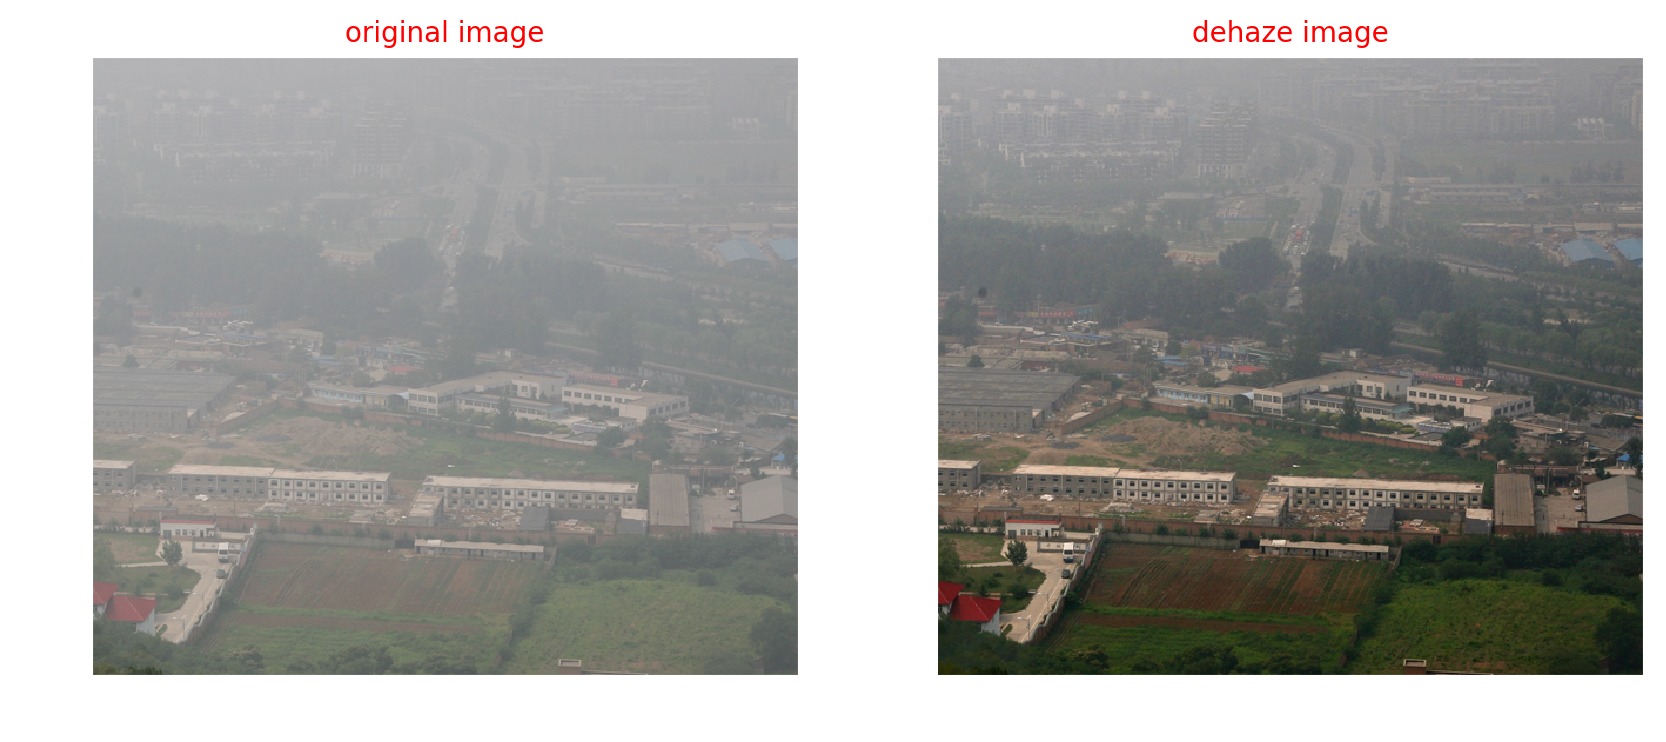

In [54]:
dark_channel_kernel_size = 15
guided_filter_kernel_size = 50
# reg=0.3**2
reg=0.0001
w = 0.95
t0=0.5
img=cv2.imread('fog1.jpg')
# img=cv2.imread('fog7.png')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = img.astype('float64') / 255
img_gray = img_gray.astype('float64') / 255
# dark_channel_kernel_size = 7
dark_channel_init = get_dark_channel_init(img,dark_channel_kernel_size)
atmospheric_light = estimate_atmospheric_light(img,dark_channel_init,percent=0.001)
dark_channel_final = get_dark_channel_final(img,atmospheric_light,dark_channel_kernel_size)
print('atmospheric_light: ',atmospheric_light)
print('dark_channel_final_min: ',np.min(dark_channel_final))
print('dark_channel_final_max: ',np.max(dark_channel_final))
transmission = estimate_transmission(dark_channel_final,w)
transmission_final = guided_filter(transmission,img_gray,guided_filter_kernel_size,reg)
# transmission_final = guided_filter2(transmission,img_gray,guided_filter_kernel_size,reg)
print('transmission_min: ',np.min(transmission))
print('transmission_max: ',np.max(transmission))
print('transmission_final_min: ',np.min(transmission_final))
print('transmission_final_max: ',np.max(transmission_final))
J=revocer_sence_radiance(img,transmission_final,atmospheric_light,t0)
# J=revocer_sence_radiance(img,transmission,atmospheric_light,t0=0.1)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.subplot(221)
plt.axis('off')
plt.title('original image',fontsize=10,color='r')
plt.imshow(BGR2RGB(img))
plt.subplot(222)
# plt.axis('off')
# plt.title('dark channel',fontsize=10,color='r')
# plt.imshow(dark_channel_final)
# plt.subplot(223)
plt.axis('off')
plt.title('dehaze image',fontsize=10,color='r')
plt.imshow(BGR2RGB(J))
# # plt.imshow(dark_channel_init)
# plt.subplot(323)
# plt.axis('off')
# plt.title('transmission',fontsize=10,color='r')
# plt.imshow(transmission)
# plt.subplot(324)
# plt.axis('off')
# plt.title('transmission_after guided filter',fontsize=10,color='r')
# plt.imshow(transmission_final)
# plt.subplot(325)
# plt.axis('off')
# plt.title('dehaze image',fontsize=10,color='r')
# plt.imshow(BGR2RGB(J))